Train shape: (1080, 64, 64, 3), Test shape: (120, 64, 64, 3)


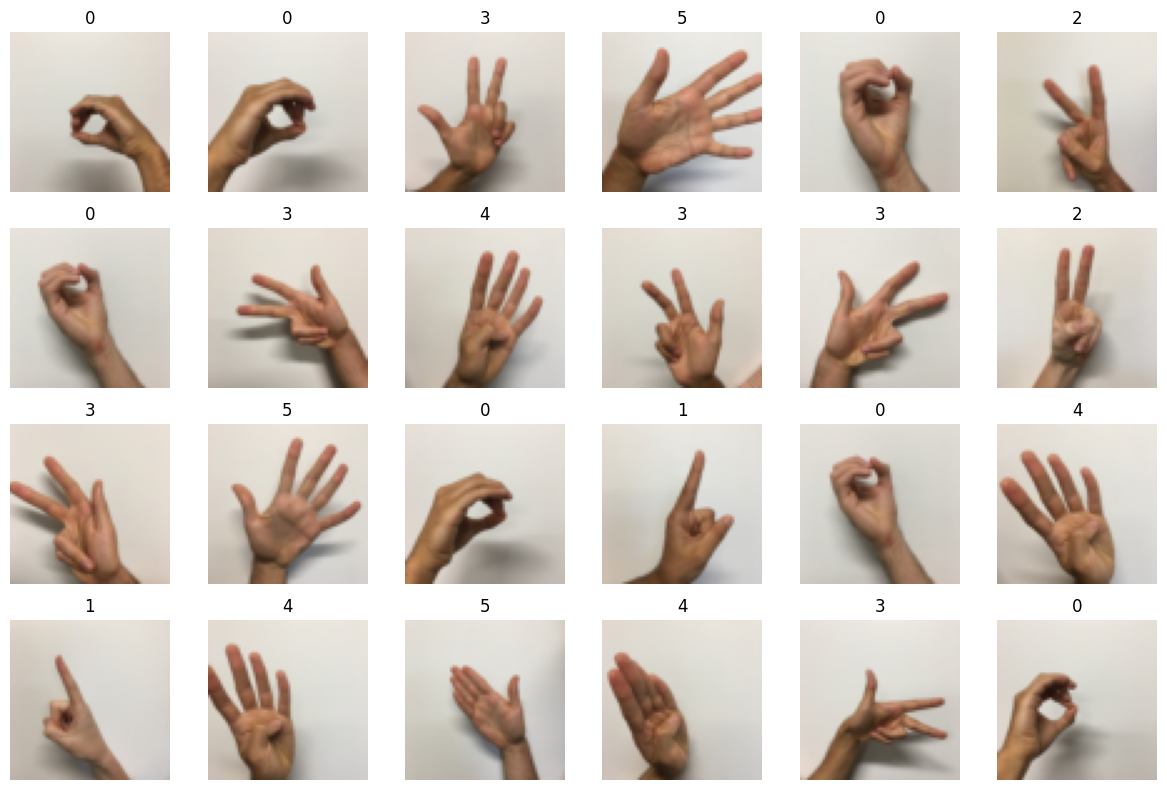

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.1895 - loss: 1.8025 - val_accuracy: 0.1917 - val_loss: 1.7597
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3329 - loss: 1.6600 - val_accuracy: 0.5000 - val_loss: 1.3064
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.4776 - loss: 1.3189 - val_accuracy: 0.4500 - val_loss: 1.2802
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.5424 - loss: 1.2100 - val_accuracy: 0.7583 - val_loss: 0.7724
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6603 - loss: 0.8685 - val_accuracy: 0.7917 - val_loss: 0.6240
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.7198 - loss: 0.7140 - val_accuracy: 0.8167 - val_loss: 0.5200
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7854 - loss: 0.6334 - val_accuracy: 0.8833 - val_loss: 0.4156
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.8014 - loss: 0.5846 - val_accuracy: 0.8833 - v

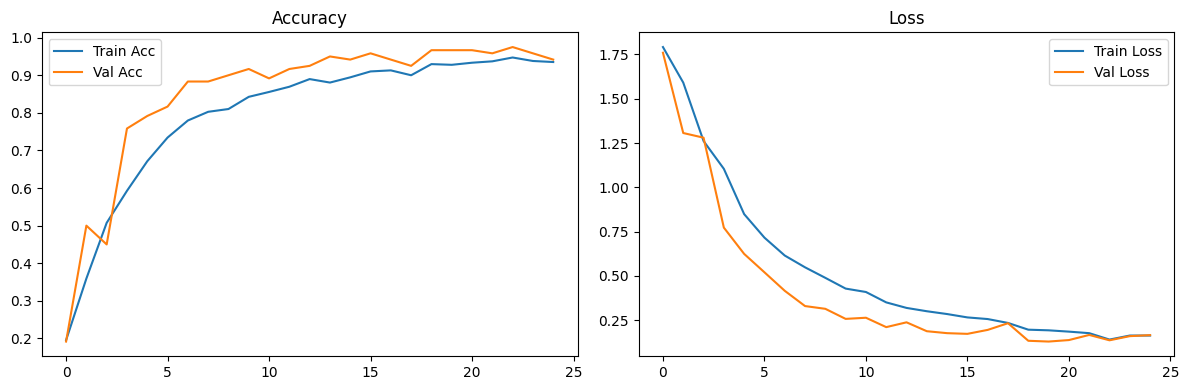


 Final Test Accuracy: 0.9667
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.91      1.00      0.95        20
           2       1.00      0.90      0.95        20
           3       0.95      1.00      0.98        20
           4       1.00      0.90      0.95        20
           5       0.95      1.00      0.98        20

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



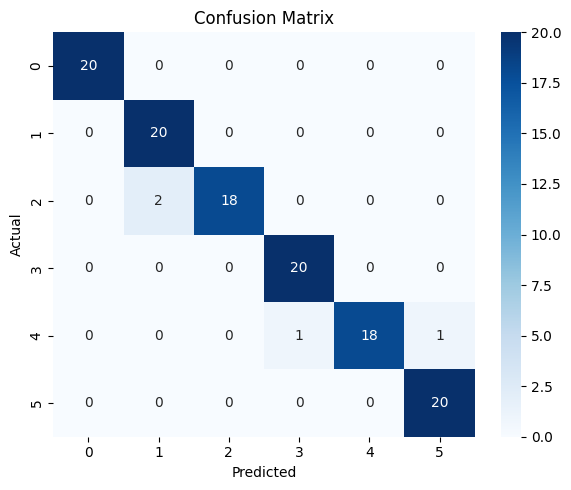

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Завантаження датасету
def load_dataset():
    with h5py.File('train_signs.h5', "r") as train_dataset:
        X_train = np.array(train_dataset["train_set_x"][:])
        Y_train = np.array(train_dataset["train_set_y"][:])
    with h5py.File('test_signs.h5', "r") as test_dataset:
        X_test = np.array(test_dataset["test_set_x"][:])
        Y_test = np.array(test_dataset["test_set_y"][:])
        classes = np.array(test_dataset["list_classes"][:])
    return X_train, Y_train, X_test, Y_test, classes


# Показ прикладів
def display_samples(X, y, rows=4, cols=6):
    indices = np.random.randint(0, len(X), rows * cols)
    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(X[indices[i]])
        plt.title(str(y[indices[i]]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Завантаження даних
X_train, y_train, X_test, y_test, classes = load_dataset()
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Візуалізація
display_samples(X_train, y_train)

# Нормалізація
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train_cat = to_categorical(y_train, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)

# Побудова CNN-моделі
model = Sequential([
    Input(shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Навчання
history = model.fit(X_train, y_train_cat,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test, y_test_cat),
                    callbacks=callbacks)

# Графіки точності/втрат
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Оцінка
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n Final Test Accuracy: {test_acc:.4f}")

# Прогнози
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Класифікаційний звіт
print("\n Classification Report:")
print(classification_report(y_test, y_pred_classes))


plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
